### Question 2 CNN for CIFAR10 dataset in PyTorch

#### To be run on GPUs


In [11]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
from sklearn.metrics import confusion_matrix

#### 2.1 (1) Torch imports

In [15]:
# Your Code Here
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

torch.__version__

'1.4.0'

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


#### Function to calculate size of output of final convolutional layer

In [17]:
def calc_image_size(layers,size_in,padding=0,kernel=3,stride=2,dilation=1):
    """layers: the number of maxPool operations
       size_in: height or width of image
       """
    for _ in range(layers):
        size_in = np.floor(((size_in + 2*padding - dilation*(kernel-1)-1)/stride)+1)
        #print(size_in)
    return int(size_in)

#### 2.2 (2) Download and transform Cifar10 data from torchvision

* The Cifar10 dataset has 3 color channels
* Show the shape of the training data and the type the test dataset

In [26]:
train_dataset = torchvision.datasets.CIFAR10(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True)

test_dataset = torchvision.datasets.CIFAR10(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True)

transformer_train = torchvision.transforms.Compose([
  transforms.RandomCrop(32, padding=4),
  torchvision.transforms.RandomHorizontalFlip(p=0.5),
  transforms.ToTensor(),])

# Your Code Here
print(train_dataset.data.shape)
print(test_dataset.data.shape)

Files already downloaded and verified
Files already downloaded and verified
(50000, 32, 32, 3)
(10000, 32, 32, 3)


#### 2.3 (1) Create train and test loaders using mini-batch size of 64

In [122]:
# Your Code Here
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)


#### 2.4 (8) Create CNN Model Class

* Create 2 blocks, conv1 and conv2 of convolutional layers using the Sequential class for each block.
    - Inside the block should be  a two conv2d classes with 32, 64 output channels, two ReLU and two Batch Normalizations  
    
* Create two linear layers, linear1 and linear2, linear1 should have an output of 1024 channels  
* In the forward function wrap linear1 in a ReLU and add a dropout layer after it  

* Hint:  Use calc_image_size  to help determining the size of the flattened image

Question 2.4.:  Add a MaxPool2d with a 2x2 kernel at the end of conv1 and conv2
    

In [123]:
# Call calc_image_size
inp_sz = calc_image_size(2,32)
# Your Code Here
print(inp_sz)

7


In [173]:
# Define the model
class CNN(nn.Module):
  def __init__(self, K):
    super(CNN, self).__init__()
    # define the conv layers, flatten and linear layers
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=6, stride=2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )
    self.linear1= nn.Linear(64, 1024)
    self.linear2 = nn.Linear(1024,K)
    
    self.flatten = nn.Flatten()
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.2)
    
    # Your Code Here
    
  def forward(self, x):
    # Your Code Here
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.flatten(x)
    x = self.relu(self.linear1(x))
    x = self.dropout(x)
    x = self.linear2(x)

    return x
    

#### 2.5 (2) Instantiate the model and display a torchsummary model summary

In [174]:
# Your Code Here
K = len(set(train_dataset.targets))
print("number of classes:", K)

model = CNN(K)
summary(model, (3,32,32))

number of classes: 10
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]           3,488
       BatchNorm2d-2           [-1, 32, 14, 14]              64
              ReLU-3           [-1, 32, 14, 14]               0
         MaxPool2d-4             [-1, 32, 7, 7]               0
            Conv2d-5             [-1, 64, 3, 3]          18,496
       BatchNorm2d-6             [-1, 64, 3, 3]             128
              ReLU-7             [-1, 64, 3, 3]               0
         MaxPool2d-8             [-1, 64, 1, 1]               0
           Flatten-9                   [-1, 64]               0
           Linear-10                 [-1, 1024]          66,560
             ReLU-11                 [-1, 1024]               0
          Dropout-12                 [-1, 1024]               0
           Linear-13                   [-1, 10]          10,250
Total params: 98,

#### 2.6 (1) Use Cross Entropy Loss and Adam optimizer with learning rate of 0.001

In [175]:
# Your Code Here
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),  lr=0.001)

#### 2.7 (5) Code training loop for 20 epochs

* Calculate both training and test loss
* Save training loss and test loss for plotting
* Print training loss and test loss at end of every epoch


In [176]:
def mini_batch_gd(model, criterion, optimizer, train_loader, test_loader, device, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      # move data to device
      inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)
        
      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading
    
    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

#### 2.8 (1) Plot the train and test loss

Epoch 1/20, Train Loss: 1.5619,       Test Loss: 1.3658, Duration: 0:00:11.345239
Epoch 2/20, Train Loss: 1.3128,       Test Loss: 1.2851, Duration: 0:00:11.164723
Epoch 3/20, Train Loss: 1.2078,       Test Loss: 1.2694, Duration: 0:00:11.316138
Epoch 4/20, Train Loss: 1.1415,       Test Loss: 1.2124, Duration: 0:00:11.368989
Epoch 5/20, Train Loss: 1.0909,       Test Loss: 1.2019, Duration: 0:00:11.204665
Epoch 6/20, Train Loss: 1.0512,       Test Loss: 1.1975, Duration: 0:00:11.344167
Epoch 7/20, Train Loss: 1.0080,       Test Loss: 1.1645, Duration: 0:00:11.263575
Epoch 8/20, Train Loss: 0.9758,       Test Loss: 1.1714, Duration: 0:00:11.311797
Epoch 9/20, Train Loss: 0.9499,       Test Loss: 1.1570, Duration: 0:00:11.491335
Epoch 10/20, Train Loss: 0.9201,       Test Loss: 1.1466, Duration: 0:00:11.430201
Epoch 11/20, Train Loss: 0.8988,       Test Loss: 1.1477, Duration: 0:00:11.455635
Epoch 12/20, Train Loss: 0.8722,       Test Loss: 1.1765, Duration: 0:00:11.374660
Epoch 13/20, 

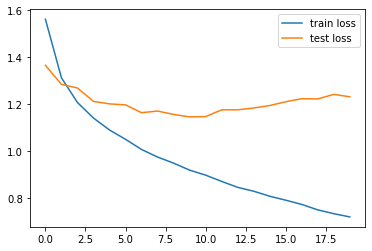

In [177]:
# Your Code Here
train_losses, test_losses = mini_batch_gd(model, criterion, optimizer, train_loader, test_loader, device, epochs=20)

# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

#### 2.9 (4 ) Predict the test data and display  results in a confusion matrix. Print the accuracy.

In [178]:
x_test = test_dataset.data
y_test = test_dataset.targets
pred_test = np.array([])
for inputs, targets in test_loader:
  # move data 
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs, 1)
  
  # update pred_test
  pred_test = np.concatenate((pred_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, pred_test)
print(cm)

print(f'Accuracy = {np.trace(cm)/np.sum(cm)}')

[[600  41  75  23  20  17  15  24 154  31]
 [ 48 696  16  11  14  13  20  14  81  87]
 [ 53  18 481  93  80  77  99  55  28  16]
 [ 20  19  79 440  77 182  93  63  20   7]
 [ 27  10  84  68 547  48  96  88  22  10]
 [ 11  17  58 186  62 529  47  68  12  10]
 [  9  16  60  70  50  26 733  18  10   8]
 [ 30  17  45  75  74  83  17 617   8  34]
 [ 77  64  20  21  13  12   7   8 737  41]
 [ 35 146  18  31  17  22  19  34  75 603]]
Accuracy = 0.5983
